<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/10_time_series_forecasing_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

**Note:** This is not a financial advice.

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin/

### Importing time series data with pandas

In [1]:
# Import with pandas 
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("drive/MyDrive/Bitcoin/BTC_data.csv",parse_dates=["Date"],index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166
2014-11-07,BTC,346.77500,336.58500,351.57500,336.02833


In [2]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-09-03,BTC,49725.532134,48834.363592,50344.664659,48619.469617
2021-09-04,BTC,49709.611994,49274.784115,51016.027011,48364.226963
2021-09-05,BTC,49999.555579,50012.441556,50558.733515,49429.569151
2021-09-06,BTC,51693.809398,49945.336568,51827.319488,49515.541880
2021-09-07,BTC,52506.685647,51764.155302,52647.551866,51026.821010


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2014-11-03 to 2021-09-07
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2500 non-null   object 
 1   Closing Price (USD)  2500 non-null   float64
 2   24h Open (USD)       2500 non-null   float64
 3   24h High (USD)       2500 non-null   float64
 4   24h Low (USD)        2500 non-null   float64
dtypes: float64(4), object(1)
memory usage: 117.2+ KB


In [4]:
# How many samples do we have?
len(df)

2500

We've collected the historical prices of Bitcoin for the past ~7 years but thers's only 2500 samples.

Typically deep learning models usually be like lots and lots of samples (from thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time-series data problems.

**Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

## Time series patterns

* **Trend:** Time series has a clear long-term increase or decrease (may or may not be linear)

* **Seasonal:** Time series affected by seasonal factors such as time of year (e.g. increased sales towards the end of year) or day of week.

* **Cyclic:** Time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

* **Univariate:** Only one variable (e.g. using the price of the Bitcoin to predict the price of Bitcoin).

* **Multivariate:** More than one variable (e.g. using the price of Bitcoin as well as the block reward size to predict the price of Bitcoin).

In [5]:
## Visualize only Date and Closing Price (USD)
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


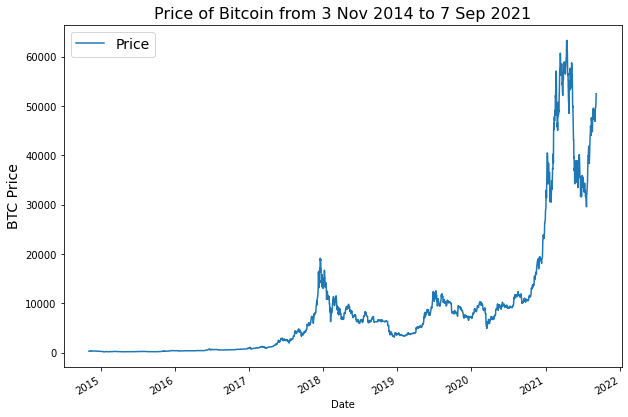

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price",fontsize=14)
plt.title("Price of Bitcoin from 3 Nov 2014 to 7 Sep 2021",fontsize=16)
plt.legend(fontsize=14);


## Importing time series data with Python's CSV module

In [7]:
# Importing and formatting historical Bitcoin data with Python
import csv
import datetime as dt

timesteps = []
btc_price = []
with open("drive/MyDrive/Bitcoin/BTC_data.csv","r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles, the header part)
  for line in csv_reader:
    timesteps.append(dt.datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10],btc_price[:10]

([datetime.datetime(2014, 11, 3, 0, 0),
  datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0),
  datetime.datetime(2014, 11, 12, 0, 0)],
 [331.60083,
  324.71833,
  332.45666,
  336.585,
  346.775,
  344.81166,
  343.065,
  358.50166,
  368.07666,
  376.99666])

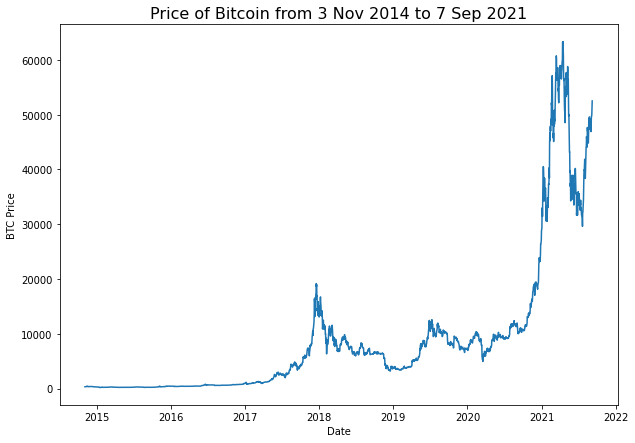

In [8]:
# Plot from CSV
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 3 Nov 2014 to 7 Sep 2021",fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [9]:
bitcoin_prices[:5]

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

timesteps[:10], prices[:10]

(array(['2014-11-03T00:00:00.000000000', '2014-11-04T00:00:00.000000000',
        '2014-11-05T00:00:00.000000000', '2014-11-06T00:00:00.000000000',
        '2014-11-07T00:00:00.000000000', '2014-11-08T00:00:00.000000000',
        '2014-11-09T00:00:00.000000000', '2014-11-10T00:00:00.000000000',
        '2014-11-11T00:00:00.000000000', '2014-11-12T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
        343.065  , 358.50166, 368.07666, 376.99666]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(timesteps,prices,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2000,), (500,), (2000,), (500,))

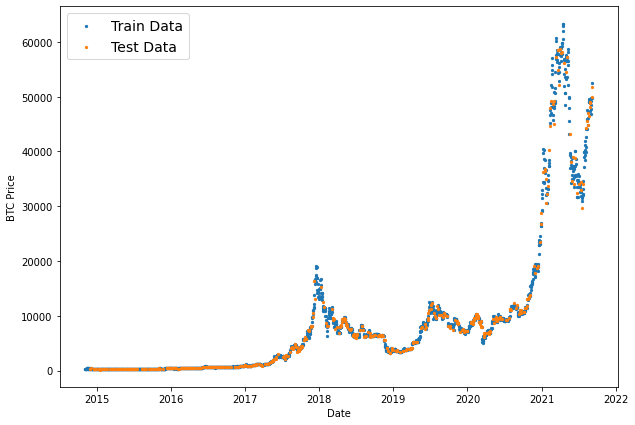

In [12]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train Data")
plt.scatter(X_test,y_test,s=5,label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);

## Create train & test sets for time series (the right way)

In [13]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test -we can change these values as needed

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2000,), (500,), (2000,), (500,))

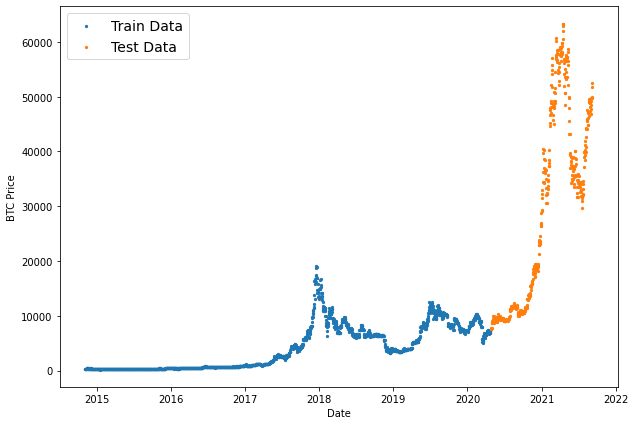

In [14]:
# Let's plot right train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train Data")
plt.scatter(X_test,y_test,s=5,label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values accross timesteps)

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values accross time
  format: style of plot, default "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to staet but for the end)
  label: label to show on plot about values, default None
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

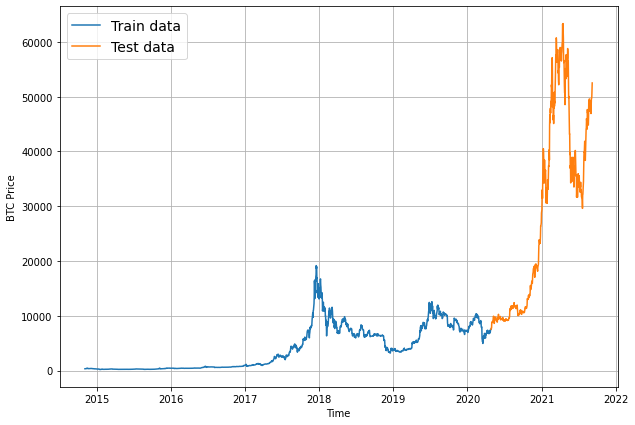

In [16]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train data",format="-")
plot_time_series(timesteps=X_test,values=y_test,label="Test data",format="-")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon:** number of timesteps into the future we're going to predict
* **Window size:** number of timesteps we're going to use to predict horizon

* Model 0: Naive model (baseline)
* Model 1: Dense model, window = 7, horizon = 1
* Model 2: Same as model 1, window = 30, horizon = 1
* Model 3: Same as model 1, window = 30, horizon = 7
* Model 4: Conv1D
* Model 5: LSTM
* Model 6: Same as model 1 (but with multivariate data)
* Model 7: N-BEATS algorithm
* Model 8: Ensemble (multiple models stacked together)
* Model 9: Future prediction model
* Model 10: Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) ~this is for a horizon of 1.

In [17]:
y_test[:10], y_test[-10:]

(array([7542.3034007 , 7624.85378592, 7776.50754257, 7761.75878408,
        8773.10648796, 8767.67262337, 8853.77448401, 8963.0575578 ,
        8904.71381654, 8887.50589259]),
 array([48768.19008652, 49184.2085095 , 47663.02250108, 46919.51155472,
        48487.01118945, 49725.53213449, 49709.61199434, 49999.55557859,
        51693.80939808, 52506.68564748]))

In [18]:
# Create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([7542.3034007 , 7624.85378592, 7776.50754257, 7761.75878408,
        8773.10648796, 8767.67262337, 8853.77448401, 8963.0575578 ,
        8904.71381654, 8887.50589259]),
 array([49033.32539607, 48768.19008652, 49184.2085095 , 47663.02250108,
        46919.51155472, 48487.01118945, 49725.53213449, 49709.61199434,
        49999.55557859, 51693.80939808]))

In [19]:
len(y_test),len(naive_forecast)

(500, 499)

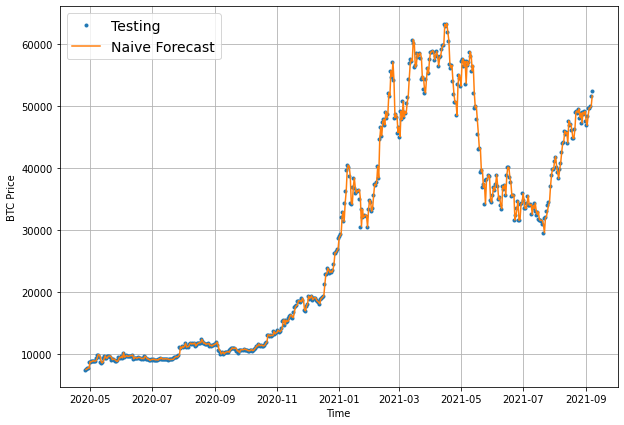

In [20]:
# Plot naive forecast
plt.figure(figsize=(10,7))
# plot_time_series(timesteps=X_train,values=y_train,label="Training data")
plot_time_series(timesteps=X_test,values=y_test,label="Testing")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

## Evaluating a time series model 

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean Absolute Error ~ as a great starter metric for any regression problem
* MSE - Mean Squared Error ~ when larger errors are more significant than smaller errors
* RMSE - Root Mean Squared Error ~ similar to MSE but as interpretable as MAE (RMSE is in same units as target)
* MAPE - (Symmetric) Mean Absolute Percentage Error (MAPE/sMAPE) ~ Recommend not to use by Hyndman & Koehler
* MASE - Mean Absolute Scaled Error ~ **A scaled error is > 1 if the forecast is worse than the naive and < 1 if the forecast is better than the naive.**

For all the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [21]:
import tensorflow as tf

In [22]:
# MASE implementation
def mean_absolute_scaled_error(y_true,y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_pred-y_true))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae/mae_naive_no_season

In [23]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9981955256551214

* Numpy uses generally float64 dtype

In [24]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds (y_true,y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = mse**0.5
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [25]:
naive_results = evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'mae': 827.59515,
 'mape': 2.602443,
 'mase': 0.9981955,
 'mse': 1765166.9,
 'rmse': 1328.5958}

In [26]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=28468.213863463643>

In [27]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=7542.303400703199>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models we can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However, there are plenty of other styles of time series forecasting models we may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/


## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

In [28]:
btc_price[:7], btc_price[7]

([331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065],
 358.50166)

In [29]:
# What we want to do with our bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065] to predict this: 358.50166


In [30]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next one day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [31]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0,1,2,3,4,5,6,7] -> Output: ([0,1,2,3,4,5,6],[7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [32]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8),axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above accross our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage Numpy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use Numpy indexing to create a 2D array of multiple window steps, for example:

```
[[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
---------------------]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

> **Resources:** The function we're about to create has been adapted from the following article:
https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [33]:
import numpy as np
# Create function to view Numpy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON): 
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  
  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T # create 2D array of windows of size window_size
  
  # 3. Index on the target array (a time series with 2D array of multiple timesteps)
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows 
  windows, labels = get_labelled_windows(x=windowed_array,horizon=horizon)
  return windows,labels

In [34]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2493, 2493)

In [35]:
# View the first 3 windows and horizon
for i in range(3):
  print(f"Window: {full_windows[i]} -> Horizon: {full_labels[i]}")

Window: [331.60083 324.71833 332.45666 336.585   346.775   344.81166 343.065  ] -> Horizon: [358.50166]
Window: [324.71833 332.45666 336.585   346.775   344.81166 343.065   358.50166] -> Horizon: [368.07666]
Window: [332.45666 336.585   346.775   344.81166 343.065   358.50166 368.07666] -> Horizon: [376.99666]


In [36]:
# View the last 3 windows and horizon
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Horizon: {full_labels[i-3]}")

Window: [48768.19008652 49184.2085095  47663.02250108 46919.51155472
 48487.01118945 49725.53213449 49709.61199434] -> Horizon: [49999.55557859]
Window: [49184.2085095  47663.02250108 46919.51155472 48487.01118945
 49725.53213449 49709.61199434 49999.55557859] -> Horizon: [51693.80939808]
Window: [47663.02250108 46919.51155472 48487.01118945 49725.53213449
 49709.61199434 49999.55557859 51693.80939808] -> Horizon: [52506.68564748]


## Turning windows into training and test sets

In [37]:
# Make the train test splits
def make_train_test_splits(windows,labels,test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # default to 80% train and 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [38]:
# Splitting the windows and labels
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1994, 499, 1994, 499)

In [39]:
train_windows[:5], train_labels[:5]

(array([[331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
         343.065  ],
        [324.71833, 332.45666, 336.585  , 346.775  , 344.81166, 343.065  ,
         358.50166],
        [332.45666, 336.585  , 346.775  , 344.81166, 343.065  , 358.50166,
         368.07666],
        [336.585  , 346.775  , 344.81166, 343.065  , 358.50166, 368.07666,
         376.99666],
        [346.775  , 344.81166, 343.065  , 358.50166, 368.07666, 376.99666,
         442.10666]]), array([[358.50166],
        [368.07666],
        [376.99666],
        [442.10666],
        [389.00333]]))

In [40]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]),y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performance against the other model's best performances.

For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.



In [41]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we have used 32)
* 100 epochs

* **Hyperparameters:** values a machine learning practitioner can adjust themselves
* **Parameters:** values a model learns on its own

In [42]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_1 = Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON,activation="linear")
],name="model_1_dense")

# Compile the model
model_1.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),
    optimizer = Adam(),
    metrics = ["mae","mse"]
)

# Fit the model
history_model_1 = model_1.fit(x=train_windows,y=train_labels,
                              epochs=100,verbose=1,batch_size=128,
                              validation_data=(test_windows,test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/16 [==============================] - 1s 15ms/step - loss: 1075.5380 - mae: 1075.5380 - mse: 3475300.5000 - val_loss: 3437.6372 - val_mae: 3437.6372 - val_mse: 22275854.0000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 340.5405 - mae: 340.5405 - mse: 394173.4688 - val_loss: 1965.5205 - val_mae: 1965.5205 - val_mse: 7630076.5000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 235.7424 - mae: 235.7424 - mse: 231472.2812 - val_loss: 1557.7600 - val_mae: 1557.7600 - val_mse: 5435897.0000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 225.4089 - mae: 225.4089 - mse: 212815.9219 - val_loss: 1460.6967 - val_mae: 1460.6967 - val_mse: 4980615.0000
INFO:tensorflow:Assets written to: mo

In [43]:
# Evaluate model on the test data
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 841.5277 - mae: 841.5277 - mse: 1825305.5000


[841.5277099609375, 841.5277099609375, 1825305.5]

In [44]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 834.4005 - mae: 834.4005 - mse: 1802183.6250


[834.4005126953125, 834.4005126953125, 1802183.625]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions


In [45]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [50]:
# Make predictions using model_1 on the test dataset
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([7562.6055, 7631.9004, 7793.8687, 7789.7383, 8619.2295, 8836.048 ,
        8910.404 , 8960.866 , 8989.898 , 8917.392 ], dtype=float32)>, 499)

In [54]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
model_1_results

{'mae': 834.4006,
 'mape': 2.6265302,
 'mase': 1.0064038,
 'mse': 1802183.6,
 'rmse': 1342.4543}

In [58]:
naive_results

{'mae': 827.59515,
 'mape': 2.602443,
 'mase': 0.9981955,
 'mse': 1765166.9,
 'rmse': 1328.5958}

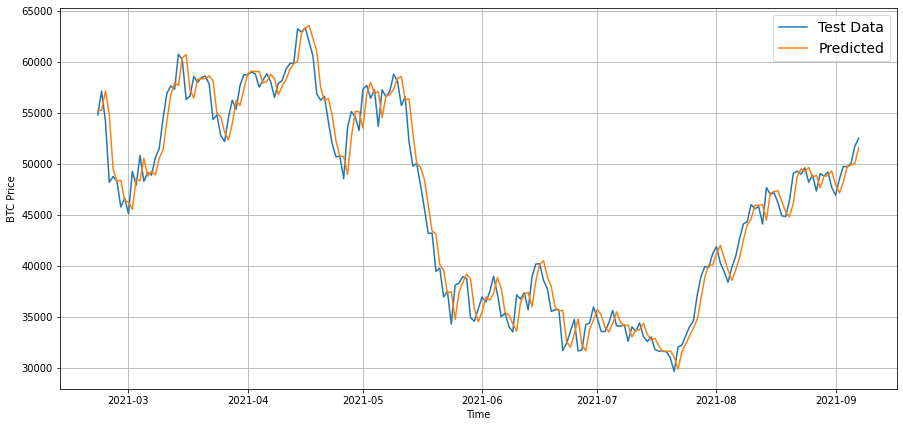

In [85]:
# Let's plot model_1 predictions
offset=300
plt.figure(figsize=(15,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 format="-",
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 format="-",
                 start=offset,
                 label="Predicted")

## Model 2: Similar to Model 1 but with window size=30 & horizon=1

In [88]:
# What we want to do with our bitcoin data
print(f"We want to use: {btc_price[:30]} to predict this: {btc_price[30]}")

We want to use: [331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065, 358.50166, 368.07666, 376.99666, 442.10666, 389.00333, 394.92666, 377.08, 400.47166, 384.93, 375.83333, 376.16, 348.565, 352.42, 356.8, 367.83, 381.20666, 375.498, 372.819, 368.983, 375.44, 376.851, 376.13218, 377.862] to predict this: 382.452


In [87]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(31),axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] -> Label: 30


In [94]:
# Make windows data with horizon
full_windows_30, full_labels_30 = make_windows(x=prices,window_size=30,horizon=1)
full_windows_30[0], full_labels_30[0]

(array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
        343.065  , 358.50166, 368.07666, 376.99666, 442.10666, 389.00333,
        394.92666, 377.08   , 400.47166, 384.93   , 375.83333, 376.16   ,
        348.565  , 352.42   , 356.8    , 367.83   , 381.20666, 375.498  ,
        372.819  , 368.983  , 375.44   , 376.851  , 376.13218, 377.862  ]),
 array([382.452]))

In [95]:
# Make train and test windows
train_windows_30,test_windows_30,train_labels_30,test_labels_30 =  make_train_test_splits(windows=full_windows_30,
                                                                                          labels=full_labels_30,
                                                                                          test_split=0.2)
len(train_windows_30),len(test_windows_30),len(train_labels_30),len(test_labels_30)

(1976, 494, 1976, 494)

In [103]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_2 = Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON,activation="linear")
],name="model_2_dense")

# Compile the model
model_2.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),
    optimizer = Adam(),
    metrics = ["mae","mse"]
)

# Fit the model
history_model_2 = model_2.fit(x=train_windows_30,y=train_labels_30,
                              epochs=100,verbose=1,batch_size=128,
                              validation_data=(test_windows_30,test_labels_30),
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
16/16 [==============================] - 1s 12ms/step - loss: 1294.1385 - mae: 1294.1385 - mse: 5387439.0000 - val_loss: 5611.2490 - val_mae: 5611.2490 - val_mse: 53130744.0000
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 526.2878 - mae: 526.2878 - mse: 1015225.9375 - val_loss: 2529.8547 - val_mae: 2529.8547 - val_mse: 15621108.0000
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 359.3816 - mae: 359.3816 - mse: 515709.4688 - val_loss: 1855.5088 - val_mae: 1855.5088 - val_mse: 8577762.0000
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 279.9393 - mae: 279.9393 - mse: 308480.7812 - val_loss: 1721.0599 - val_mae: 1721.0599 - val_mse: 7085594.0000
INFO:tensorflow:Assets written to: 

In [105]:
# Load in the best saved model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows_30, test_labels_30)

16/16 [==============================] - 0s 1ms/step - loss: 894.8816 - mae: 894.8816 - mse: 2003243.5000


[894.881591796875, 894.881591796875, 2003243.5]

In [106]:
model_2_preds = make_preds(model_2, input_data=test_windows_30)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 8858.688,  8898.962,  9138.405,  8952.882,  9031.64 ,  9030.863,
        9264.19 ,  9792.532, 10087.992,  9772.31 ], dtype=float32)>

In [107]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels_30),y_pred=model_2_preds)
model_2_results

{'mae': 894.8816,
 'mape': 2.805764,
 'mase': 1.0718104,
 'mse': 2003243.5,
 'rmse': 1415.3599}

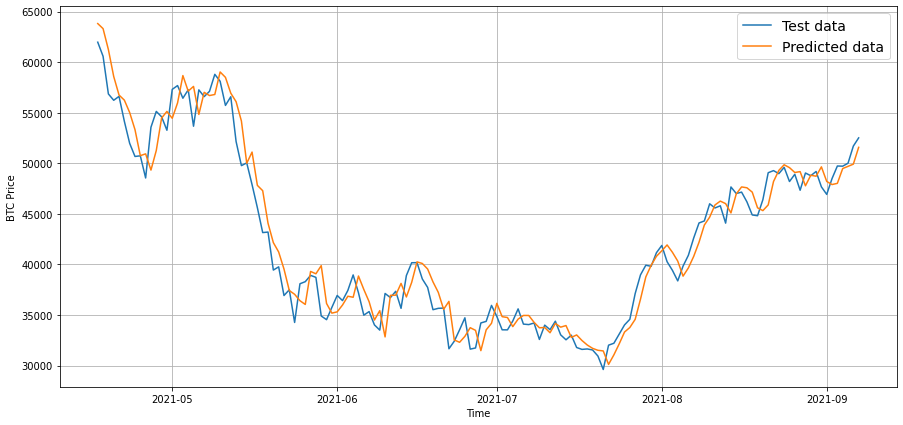

In [110]:
# Plot model 2 predictions
offset=350
plt.figure(figsize=(15,7))
plot_time_series(timesteps=X_test[-len(test_windows_30):],
                 values=test_labels_30,
                 format="-",
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows_30):],
                 values=model_2_preds,
                 format="-",
                 start=offset,
                 label="Predicted data")
